<a href="https://colab.research.google.com/github/suaviq/diabetic-retinopathy-detection/blob/main/kaggle_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting drive and imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [73]:
import pandas as pd
import zipfile
import numpy as np
import os
from PIL import Image, ImageFilter
import shutil
import random
from PIL import Image, ImageEnhance, ImageOps, ImageFile
import random
import re

In [4]:
! cp /content/drive/MyDrive/engineer/kaggle.json /content/

# Download data from kaggle and unzip

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c diabetic-retinopathy-detection
! kaggle competitions download -c diabetic-retinopathy-detection -f train.zip.001
! kaggle competitions download -c diabetic-retinopathy-detection -f train.zip.002

100% 7.81G/7.81G [05:17<00:00, 23.5MB/s]
100% 7.81G/7.81G [05:17<00:00, 26.4MB/s]
100% 7.81G/7.81G [05:15<00:00, 28.5MB/s]
100% 7.81G/7.81G [05:15<00:00, 26.6MB/s]


In [6]:
! pip install patool
! mkdir ./diabetic-retinopathy-detection
import patoolib
patoolib.extract_archive("/content/train.zip.001.zip",outdir="/content/")
! rm /content/train.zip.001.zip
patoolib.extract_archive("/content/train.zip.002.zip",outdir="/content/")
! rm /content/train.zip.002.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 2.0 MB/s eta 0:00:00


INFO patool: Extracting /content/train.zip.001.zip ...
INFO:patool:Extracting /content/train.zip.001.zip ...
INFO patool: running /usr/bin/7z x -o/content/ -- /content/train.zip.001.zip
INFO:patool:running /usr/bin/7z x -o/content/ -- /content/train.zip.001.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/train.zip.001.zip extracted to `/content/'.
INFO:patool:... /content/train.zip.001.zip extracted to `/content/'.
INFO patool: Extracting /content/train.zip.002.zip ...
INFO:patool:Extracting /content/train.zip.002.zip ...
INFO patool: running /usr/bin/7z x -o/content/ -- /content/train.zip.002.zip
INFO:patool:running /usr/bin/7z x -o/content/ -- /content/train.zip.002.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/train.zip.002.zip extracted to `/content/'.
INFO:patool:... /content/train.zip.002.zip extracted to `/content/'.


In [7]:
def unzip_folders(folder_names, dest_folder):
  if os.path.exists(dest_folder):
    pass
  else:
    os.mkdir(dest_folder)

  for folder_name in folder_names:
    try:
      patoolib.extract_archive(f"/content/{folder_name}",outdir=dest_folder)
    except Exception as e:
      print(e)
      pass

folder_names = ['train.zip.001', 'train.zip.002']
dest_folder = "/content/dr_detection/"
unzip_folders(folder_names, dest_folder)

INFO patool: Extracting /content/train.zip.001 ...
INFO:patool:Extracting /content/train.zip.001 ...
INFO patool: running /usr/bin/7z x -o/content/dr_detection/ -- /content/train.zip.001
INFO:patool:running /usr/bin/7z x -o/content/dr_detection/ -- /content/train.zip.001
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: Extracting /content/train.zip.002 ...
INFO:patool:Extracting /content/train.zip.002 ...


Command `['/usr/bin/7z', 'x', '-o/content/dr_detection/', '--', '/content/train.zip.001']' returned non-zero exit status 2
unknown archive format for file `/content/train.zip.002'


In [8]:
len(os.listdir('/content/dr_detection/train'))

16802

In [9]:
! cp -r /content/dr_detection/train/* /content/dr_detection/
! rmdir /content/dr_detection/train

#Data processing
- resizing images to 224x224x3
- sorting images based on trainLabels.csv
- balancing images with random data augmentation

In [99]:
retina_df = pd.read_csv('/content/drive/MyDrive/engineer/trainLabels.csv')
images_path = '/content/dr_detection/'
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(images_path,
                                                         '{}.jpeg'.format(x)))
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
retina_df['exists_in_colab'] = retina_df['path'].map(lambda x: 1 if os.path.exists(str(x).strip()) else 0)
retina_df.dropna(inplace = True)
retina_df.head(10)

,image,level,PatientId,path,eye,exists_in_colab
0,10_left,0,10,/content/dr_detection/10_left.jpeg,1,1
1,10_right,0,10,/content/dr_detection/10_right.jpeg,0,1
2,13_left,0,13,/content/dr_detection/13_left.jpeg,1,1
3,13_right,0,13,/content/dr_detection/13_right.jpeg,0,1
4,15_left,1,15,/content/dr_detection/15_left.jpeg,1,1
5,15_right,2,15,/content/dr_detection/15_right.jpeg,0,1
6,16_left,4,16,/content/dr_detection/16_left.jpeg,1,1
7,16_right,4,16,/content/dr_detection/16_right.jpeg,0,1
8,17_left,0,17,/content/dr_detection/17_left.jpeg,1,1
9,17_right,1,17,/content/dr_detection/17_right.jpeg,0,1


In [150]:
current = retina_df[retina_df['exists_in_colab'] == 1]

In [48]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def resize_images(folder):
    for file in os.listdir(folder):
      path = os.path.join(folder, file)
      image = Image.open(path)
      image = image.resize((224, 224))#.convert('L')
      image.save(path)

folder = '/content/dr_detection'
resize_images(folder)

In [101]:
def sort_images(folder_name):
  folders = [0, 1]
  for folder in folders:
    if os.path.isdir(os.path.join(folder_name, str(folder))):
      pass
    else:
      os.mkdir(os.path.join(folder_name, str(folder)))

  folders = pd.DataFrame()
  folders['image'] = current['image']
  folders['source_folder'] = current['path']
  folders['class'] = current['level']#current['level'].apply(lambda x: 0 if x == 0 else 1)
  folders['dest_folder'] = (folder_name + '/' + folders['class'].map(str)
                          + '/' + current['image'].map(lambda x: '{}.jpeg'.format(x)))
  for idx in folders.index:
    if os.path.isdir(folder_name):
      os.rename(folders['source_folder'][idx], folders['dest_folder'][idx])
    else:
      pass

sort_images('/content/dr_detection')

In [147]:
def delete_doubled_images(directory):
    files = os.listdir(directory)
    pattern = re.compile("\d+\_+[a-z]+\_+\d+\.jpeg$")
    for file in files:
        if pattern.match(file):
            file_path = os.path.join(directory, file)
            try:
                os.remove(file_path)
                # print(f"Deleted: {file_path}")
            except Exception as e:
                print(f"Error deleting {file_path}: {e}")
                continue

# delete_doubled_images("/content/dr_detection/0")

In [71]:
! mv /content/dr_detection/.ipynb_checkpoints /content/.ipynb_checkpoints

mv: cannot stat '/content/dr_detection/.ipynb_checkpoints': No such file or directory


In [145]:
def random_data_augmentation(image, number):
  if number == 0:
      return image.transpose(Image.FLIP_LEFT_RIGHT)
  elif number == 1:
      return image.transpose(Image.FLIP_TOP_BOTTOM)
  elif number == 2:
      enhancer = ImageEnhance.Brightness(image)
      enhanced_image = enhancer.enhance(0.9)
      return enhanced_image
  elif number == 3:
      enhancer = ImageEnhance.Brightness(image)
      enhanced_image = enhancer.enhance(1.1)
      return enhanced_image
  elif number == 4:
      width, height = image.size
      crop_percentage = 2
      left = (width - int(width * (crop_percentage / 100))) / 2
      top = (height - int(height * (crop_percentage / 100))) / 2
      right = (width + int(width * (crop_percentage / 100))) / 2
      bottom = (height + int(height * (crop_percentage / 100))) / 2
      cropped_image = image.crop((left, top, right, bottom))
      return cropped_image
  else:
      return image.rotate(180)

def balance_data(folder_name):
  max_files_count = max([len(os.listdir(os.path.join(folder_name, folder))) for folder in os.listdir(folder_name)])
  for folder in os.listdir(folder_name):
    folder = os.path.join(folder_name, folder)
    print(f"Currently in folder {folder}")
    images = os.listdir(folder)
    for i in range(int(max_files_count/len(images))-1):
      for j in range(len(images)):
          original_image = Image.open(os.path.join(folder, images[j]))
          transformed_image = random_data_augmentation(original_image, random.randint(1, 3))
          transformed_image.save(os.path.join(folder, f'{images[j][:-5]}_{i}.jpeg'))


balance_data('/content/dr_detection/')

Currently in folder /content/dr_detection/1
Currently in folder /content/dr_detection/0


In [148]:
print(len(os.listdir('/content/dr_detection/0')))
print(len(os.listdir('/content/dr_detection/1')))

12387
13245


# Put processed data in GCS bucket

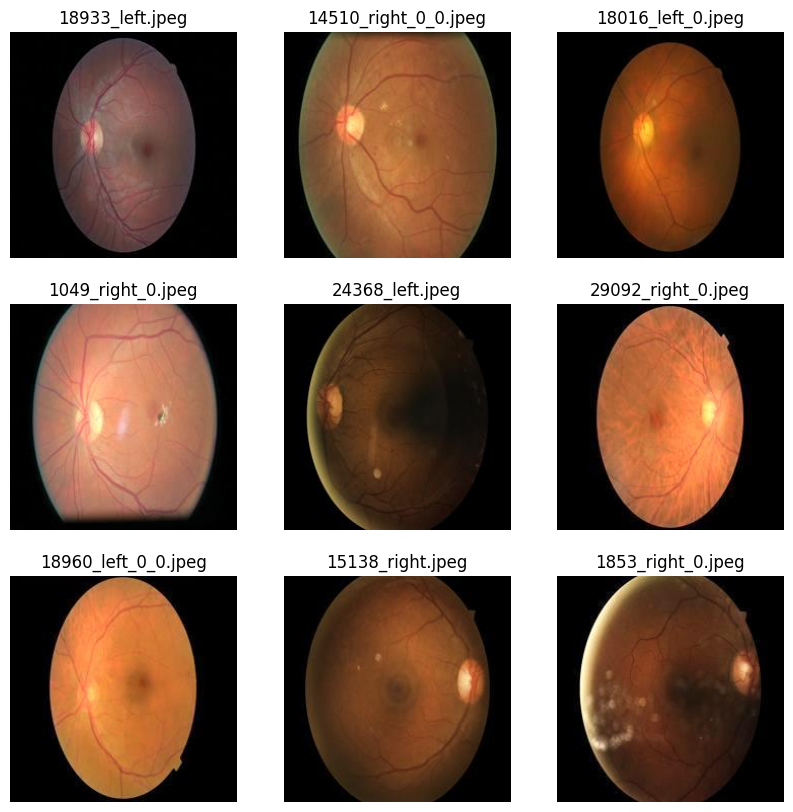

In [149]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

folder_path = "/content/dr_detection/1"
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
random_images = random.sample(image_files, min(9, len(image_files)))
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < len(random_images):
        image_path = os.path.join(folder_path, random_images[i])
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(random_images[i])

plt.show()


In [105]:
from google.colab import auth
auth.authenticate_user()

In [106]:
%%capture
! curl https://sdk.cloud.google.com | bash

In [ ]:
!gcloud init

In [151]:
%%capture
! gsutil -m cp -r /content/dr_detection/* gs://as_bachelor_thesis_93273